In [135]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cv2
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [48]:
# Covert ClassName to Integer method
def label_s2n(x):
    return {
        'Black-grass': 0,
        'Charlock': 1,
        'Cleavers': 2,
        'Common Chickweed': 3,
        'Common wheat': 4, 
        'Fat Hen': 5,
        'Loose Silky-bent': 6,
        'Maize': 7,
        'Scentless Mayweed': 8,
        'Shepherds Purse': 9,
        'Small-flowered Cranesbill': 10,
        'Sugar beet': 11
    }.get(x, 12)

def label_n2s(x):
    return {
        0: 'Black-grass',
        1: 'Charlock',
        2: 'Cleavers',
        3: 'Common Chickweed',
        4: 'Common wheat', 
        5: 'Fat Hen',
        6: 'Loose Silky-bent',
        7: 'Maize',
        8: 'Scentless Mayweed',
        9: 'Shepherds Purse',
        10: 'Small-flowered Cranesbill',
        11: 'Sugar beet'
    }.get(x, 'None')

In [47]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
             'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

scaleSize = 300 #resize figures to 300 px
seed = 0        #random seed

path='Dataset/train/*/*.png'
files = glob(path)

trainImage = []
trainLabel = []
j = 1
num = len(files)

for img in files:
    if (j >= num):
        print(str(j)+"/"+str(num), end="\r")
    trainImage.append(cv2.resize(cv2.imread(img), (scaleSize, scaleSize)))
    trainLabel.append(img.split('/')[1].split('\\')[-2])   #Depends on the path of dataset, MODIFY
    j = j + 1
    
trainImage = np.asarray(trainImage)
trainLabel = pd.DataFrame(trainLabel)

In [59]:
# Covert Categories into Label Numbers
trainLabels = []
for i in range(trainLabel.shape[0]):
    trainLabels.append(label_s2n(trainLabel[0][i]))

SIFT Example - Original

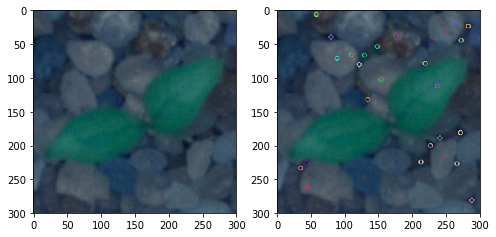

In [55]:
sift = cv2.xfeatures2d.SIFT_create()
example = trainImage[978]
kp = sift.detect(example, None)
sift_image = cv2.drawKeypoints(example, kp, None)
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(example)
ax[1].imshow(sift_image)

Preprocess the image - mask, blurred, segment, sharp

In [56]:
clearTrainImage = []
maskTrainImage = []
blurredTrainImage = []
segmentTrainImage = []
sharpTrainImage = []
examples = []
getEx = True
for image in trainImage:
    #Gaussian blur
    #blurImage = cv2.GaussianBlur(image, (5,5), 0)
    
    #Convert to HSV
    hsvImage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #Create mask
    sensitivity = 35
    green_lb = (60 - sensitivity, 100, 50) #lower bound of green range
    green_ub = (60 + sensitivity, 255, 255) #upper bound of green range
    mask = cv2.inRange(hsvImage, green_lb, green_ub)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    #segment image
    segmentImage = cv2.bitwise_and(image, image, mask = mask)
    
    #sharpen
    blurredImage = cv2.GaussianBlur(segmentImage, (5,5), 0)
    sharpImage = cv2.addWeighted(segmentImage, 1.5, blurredImage, -0.5, 0)
    maskTrainImage.append(mask)
    segmentTrainImage.append(segmentImage)
    blurredTrainImage.append(blurredImage)
    sharpTrainImage.append(sharpImage)

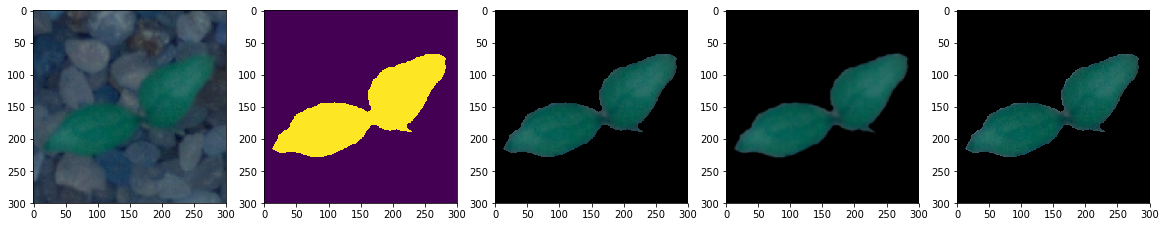

In [57]:
fig, axs = plt.subplots(1,5, figsize=(20,20))
axs[0].imshow(trainImage[978])
axs[1].imshow(maskTrainImage[978])
axs[2].imshow(segmentTrainImage[978])
axs[3].imshow(blurredTrainImage[978])
axs[4].imshow(sharpTrainImage[978])

SIFT Example - Sharpened

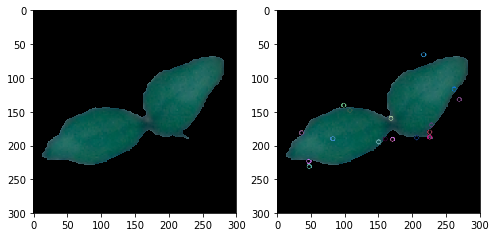

In [58]:
kp = sift.detect(sharpTrainImage[978], None)
sift_image = cv2.drawKeypoints(sharpTrainImage[978], kp, None)
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(sharpTrainImage[978])
ax[1].imshow(sift_image)

Validation Set 9:1

In [139]:
X_train,X_valid, y_train, y_valid = train_test_split(sharpTrainImage, trainLabels, test_size=0.1, random_state=42)

In [89]:
sift = cv2.xfeatures2d.SIFT_create()
des_total = []
for image in X_train:
    kp, des = sift.detectAndCompute(image,None)
    if (len(kp) > 0):
        for array in des:
            des_total.append(array)
        
des_total = np.asarray(des_total)
print("Number of SIFT des in total: ", des_total.shape)

Number of SIFT des in total:  (212712, 128)


In [134]:
def histogram(pred):
    feature = np.zeros((n_clusters,1))
    for c in pred:
        feature[c] += 1 
    return feature

def Feature_Extraction(ImageSet, ImageLabel):
    features = []
    labels = []
    for i in range(len(ImageSet)):
        kp, des = sift.detectAndCompute(ImageSet[i],None)
        if (len(kp) > 0):
            kMean_pred = kmeans.predict(des)
            features.append(histogram(kMean_pred))
            labels.append(ImageLabel[i])
    return features, labels

## n_cluster TUNE

In [90]:
n_clusters = 50          
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(des_total)

In [96]:
train_feature, train_label = Feature_Extraction(X_train, y_train)
valid_feature, valid_label = Feature_Extraction(X_valid, y_valid)

## C SVM TUNE

In [138]:
svm = SVC()    # C?
svm.fit(train_feature, train_label)

train_pred = svm.predict(train_feature)
train_score = svm.score(train_feature, train_label)

valid_score = svm.score(valid_feature, valid_label)

print("Accuracy for Train set= ", train_score)
print("Accuracy for Validation set= ", valid_score)

C:\Users\yixin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for Train set=  0.85904940295
Accuracy for Validation set=  0.669473684211


### Hyperparameter to tune : n_clusters (K-means), C (SVC)?